In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import bempp.api
from bempp.api import shapes
import bempp_cavity

# Define Mesh

In [3]:
ELEMENT_SIZE = 0.5
LENGTH_CAVITY = 1
LENGTH_WALL = 3

In [4]:
inner_walls = [
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(-1.25, -1/2, -1.25)
    ),
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(0.25, -1/2, -1.25)
    ),
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(-1.25, -1/2, 0.25)
    ),
    shapes.cube(
        length=1, h=ELEMENT_SIZE,
        origin=(0.25, -1/2, 0.25)
    ), 
]
outer_wall = shapes.cube(
        length=LENGTH_WALL, h=ELEMENT_SIZE,
        origin=(-LENGTH_WALL/2, -LENGTH_WALL/2, -LENGTH_WALL/2)
)
grid = bempp_cavity.create_grid(outer_wall, *inner_walls)

# Define Parameters and incident wave

In [21]:
Ks = [1, 1, 1, 1, 1, 1]
MUs = [1, 1, 1, 1, 1, 1]
wave = bempp_cavity.IncidentWave(Ks[0], MUs[0])

1 1


In [7]:
parameters = bempp_cavity.Parameters(
    nearfield_cutoff=1.0,
    ACA=0.1,
    quadrature=(1, 1, 1, 1)
)

# Create Models and Solve Them

In [8]:
residuals_sf = {}
residuals_wf = {}
info_sf = {}
info_wf = {}

In [9]:
methods = [
#     'self',
#     'diagonal',
    'none', 
]

In [22]:
for method in methods:
    print(method)
    model = bempp_cavity.Model(grid, Ks, MUs, wave)
    sol = model.solve(preconditioner=method)
    residuals_sf[method] = sol.residuals
    info_sf[method] = sol.info
#     del sol
    del model

none


In [11]:
for method in methods:
    print(method)
    model = bempp_cavity.Model(grid, Ks, MUs, wave, spaces='RWG-dominant')
    sol = model.solve(preconditioner=method, preconditioner_parameters=parameters.get())
    residuals_wf[method] = sol.residuals
    info_wf[method] = sol.info
    del sol
    del model

none


# Analyse Results

## Convergence

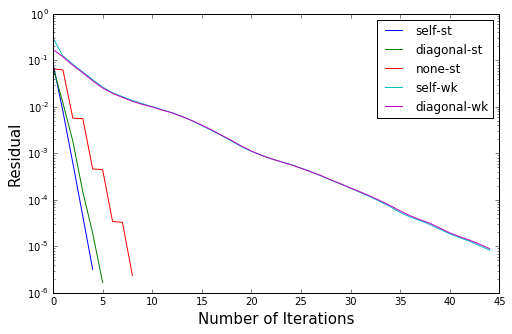

In [80]:
for method in methods:
    if method in residuals_sf:
        plt.semilogy(residuals_sf[method], label=method+'-st')
for method in residuals_wf:
    if method in residuals_wf and method is not 'none':
        plt.semilogy(residuals_wf[method], label=method+'-wk')
plt.legend()
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Residual', fontsize=15)
plt.gcf().set_size_inches(8, 5)
plt.show();

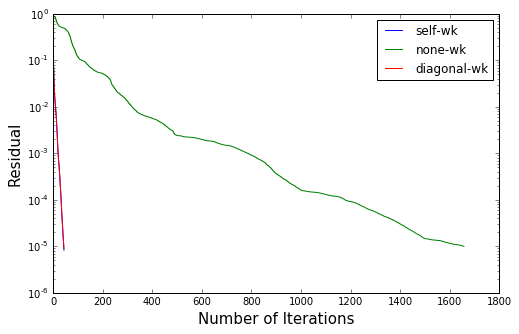

In [85]:
for method in residuals_wf:
    if method in residuals_wf:
        plt.semilogy(residuals_wf[method], label=method+'-wk')
plt.legend()
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Residual', fontsize=15)
plt.gcf().set_size_inches(8, 5)
plt.show();

# Fancy Plot

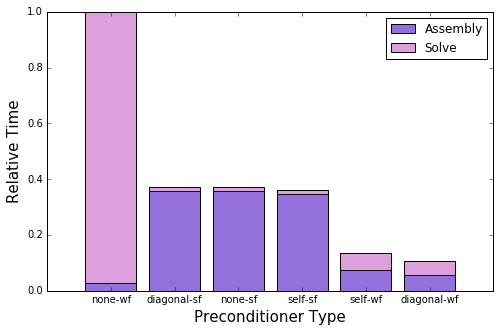

In [77]:
sol = {}
for k, v in info_sf.items():
    sol[k+'-sf'] = v
for k, v in info_wf.items():
    sol[k+'-wf'] = v

def get(metric):
    ref = sol['none-wf']['time_assemble'] + sol['none-wf']['time_solve']
    return list((key for key in sol)), \
        list((sol[key][metric]/ref for key in sol))


width = 0.8
_, t_assembly = get('time_assemble')
labels, t_solve = get('time_solve')
total = [a + b for a, b in zip(t_assembly, t_solve)]
sorts = sorted(zip(total, labels, t_solve, t_assembly), reverse=True)
t_assembly = [x[-1] for x in sorts]
t_solve = [x[-2] for x in sorts]
labels = [x[1] for x in sorts]
ind = np.arange(len(labels))

p1 = plt.bar(
    ind, t_assembly, width,
    align='center', label='Assembly',
    color='mediumpurple'
)
p2 = plt.bar(ind, t_solve, width,
             bottom=t_assembly, align='center',
             label="Solve", color='plum')

plt.xlabel('Preconditioner Type', fontsize=15)
plt.ylabel('Relative Time', fontsize=15)
plt.xticks(ind, labels)
plt.legend();
fig = plt.gcf()
fig.set_size_inches(8, 5)

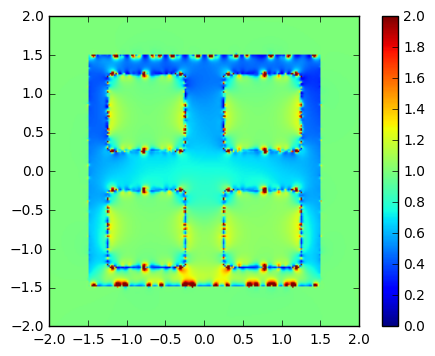

In [23]:
sol.plot()